In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

import time

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("MODEL LOADED ON: ", device)
model.to(device)

MODEL LOADED ON:  cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
##### PARAMETERS ######

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[5, 15, 25], gamma=0.1)
epochs = 30
batch_size = 64

In [ ]:
# Data for normalization was taken from internet
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


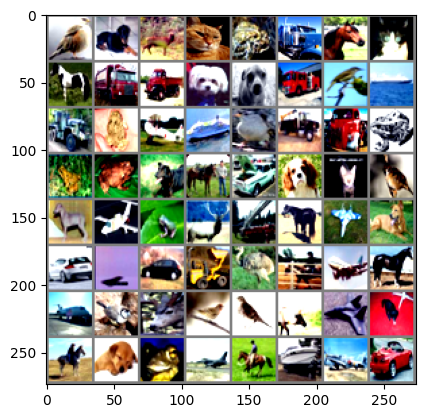

bird  dog   deer  cat   frog  truck horse cat   horse truck truck dog   dog   truck bird  ship  truck frog  plane ship  bird  truck truck frog  frog  frog  dog   horse car   dog   cat   bird  dog   plane frog  deer  truck horse plane dog   car   plane car   truck bird  horse plane horse plane bird  deer  bird  bird  deer  plane dog   horse dog   frog  plane horse ship  plane car  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
def train_epoch(model, criterion, optimizer, train_loader, epoch):
    model.train()
    losses = []

    for i, (data, labels) in enumerate(train_loader):
      data, labels = data.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

    return np.mean(losses)

In [ ]:
def test_epoch(model, criterion, optimizer, test_loader, epoch):
  model.eval()
  losses = []
  correct = 0
  total = 0
  with torch.no_grad():
    for i, (data, labels) in enumerate(test_loader):
      data, labels = data.to(device), labels.to(device)
      outputs = model(data)
      loss = criterion(outputs, labels)
      losses.append(loss.item())

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct // total
  return np.mean(losses), accuracy

In [ ]:
train_losses = []
test_losses = []
accuracies = []
for epoch in range(1, epochs + 1):
  print(f'Epoch {epoch}/{epochs}')
  print('-' * 10)

  train_losses.append(train_epoch(model, loss_fn, optimizer, train_loader, epoch))
  test_loss, acc = test_epoch(model, loss_fn, optimizer, test_loader, epoch)
  test_losses.append(test_loss)
  accuracies.append(acc)
  scheduler.step()


Epoch 1/30
----------
Epoch 2/30
----------
Epoch 3/30
----------
Epoch 4/30
----------
Epoch 5/30
----------
Epoch 6/30
----------
Epoch 7/30
----------
Epoch 8/30
----------
Epoch 9/30
----------
Epoch 10/30
----------
Epoch 11/30
----------
Epoch 12/30
----------
Epoch 13/30
----------
Epoch 14/30
----------
Epoch 15/30
----------
Epoch 16/30
----------
Epoch 17/30
----------
Epoch 18/30
----------
Epoch 19/30
----------
Epoch 20/30
----------
Epoch 21/30
----------
Epoch 22/30
----------
Epoch 23/30
----------
Epoch 24/30
----------
Epoch 25/30
----------
Epoch 26/30
----------
Epoch 27/30
----------
Epoch 28/30
----------
Epoch 29/30
----------
Epoch 30/30
----------


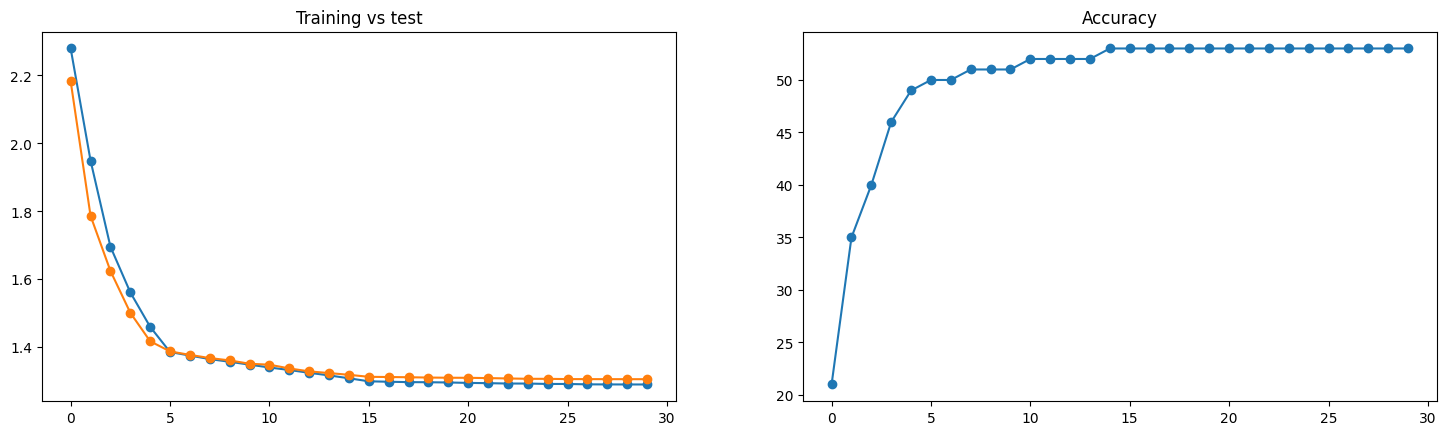

In [ ]:
train_loss = np.array(train_losses).ravel()
test_loss = np.array(test_losses).ravel()
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(18)
ax[0].set_title("Training vs test")
ax[1].set_title("Accuracy")
ax[0].plot(np.arange(0, len(train_losses), 1), train_loss, '-o')
ax[0].plot(np.arange(0, len(test_losses), 1), test_loss, '-o')
ax[1].plot(np.arange(0, epochs, 1), accuracies, '-o')

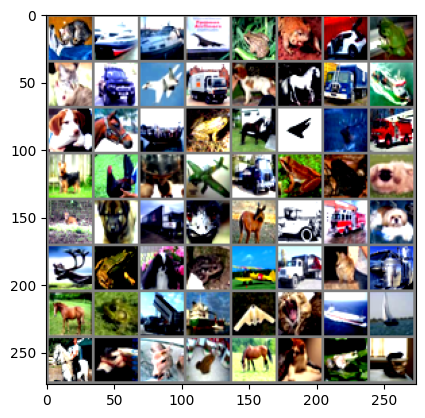

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


Predicted:  horse car   car   deer 


In [ ]:

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 17.2 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 88.3 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.3 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %


### Exercise 1
Try to use a scheduler for the learning rate (https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

- What are the differences?
- Does it improves the training convergence/test accuracy?

In [ ]:
""" Example of usage
    >>> scheduler = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    >>> for epoch in range(100):
    >>>     train(...)
    >>>     test(...)
    >>>     scheduler.step()
"""



net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
train_loss = []
test_loss = []
for epoch in range(20):  # loop over the dataset multiple times
    print("epoch: ", epoch)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        train_loss.append(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    scheduler.step()

print('Finished Training')

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
Finished Training


TypeError: ignored

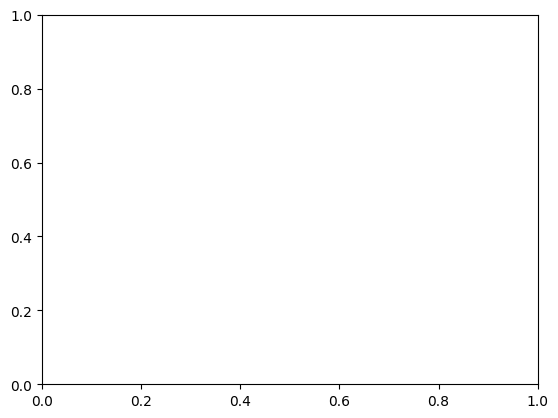

In [ ]:
import matplotlib.pyplot as plt
loss = []
for i in range(len(train_loss)):
  train_loss[i].cpu()
  loss.append((train_loss[i].item()))

loss = np.array(loss).ravel
plt.plot(train_loss, np.arange(0, len(train_loss), 1), '-o')

In [ ]:

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


RuntimeError: ignored

## Exercise 2

Use some data augmentation to reduce overfitting.

All the transformations supported by PyTorch can be found at https://pytorch.org/vision/0.9/transforms.html#compositions-of-transforms

- Which transformations are the most impactfull on the accuracies?

Try to plot the effect of the transformations!

In [ ]:
transform = transforms.Compose([
                        ## add more here
                        transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)

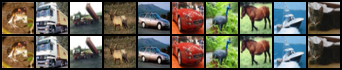

In [ ]:
# plot real and augmented images
from torchvision.utils import make_grid
notransform = transforms.Compose([transforms.ToTensor()])
non_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, transform=notransform)

imgs = torch.stack((*[non_augmented[i][0] for i in range(10)],
                    *[trainset[i][0] for i in range(10)]))
grid = make_grid(imgs, nrow=10)

transforms.ToPILImage()(grid)

Now use it to train the your model

## Exercise 3
A) Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding).

B) Try also to compare performance of your model with performance of pre-defined network architecture.
There are a lot of pre-defined network architectures (e.g. ResNet, VGG, AlexNet, ...).

Some example can be found in https://pytorch.org/vision/0.9/models.html.

Specific CIFAR10 architectures are also in this public repository https://github.com/kuangliu/pytorch-cifar.

In [ ]:
import torchvision.models as models

alexnet = models.alexnet()
resnet18 = models.resnet18()
vgg16 = models.vgg16()